# Lab 3
**Joseph Livesey**

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats, signal

## Problem 1

Oftentimes we encounter noise due to the instrumentation in our experiments. We can eliminate much of the "bad data" due to this noise by establishing a statistical threshold, beyond which we eliminate any anomalous readings. The following distribution and "bad data" were taken from the lab assignment.

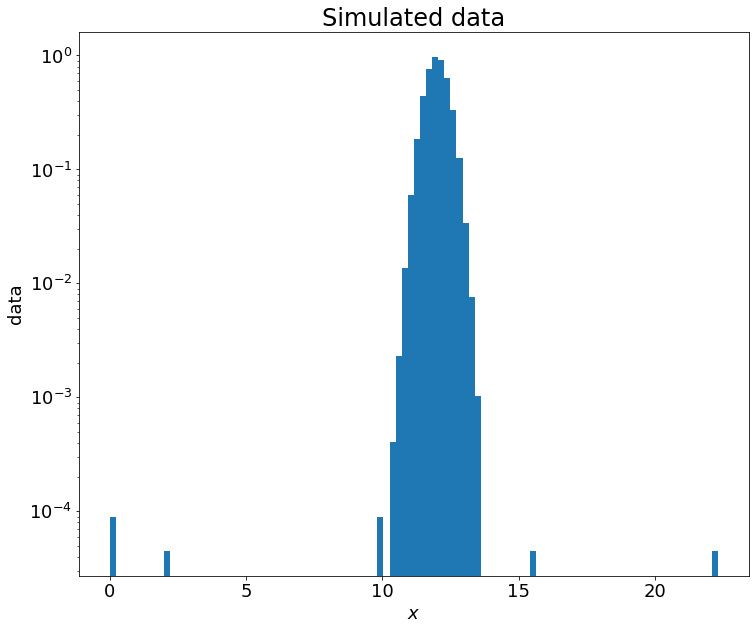

In [2]:
data = np.append(stats.norm.rvs(loc = 12., scale = 0.4, size = 100000), [10., 10.3, 2.1, 0., 0., 15.6, 22.3, 12.7])

fig, ax = plt.subplots(1, 1, figsize=(12, 10))
ax.hist(data, 100, density=True)
ax.set_title('Simulated data', fontsize=24)
ax.set_xlabel(r'$x$', fontsize=18)
ax.set_ylabel(r'data', fontsize=18)
plt.tick_params(labelsize=18)
plt.yscale('log')
plt.show()

In order to eliminate these points, we can establish some probability threshold that good data may not lie beyond. Our statistical question might therefore be: How many data points have a probability less than $4\sigma$? In math, for how many data points satisfy

$$ \frac{x - \mu}{\sigma} > 4. $$

This gives the corresponding value in the standard normal distribution (sigma value).

In [3]:
def good(x, mean, stdev):
    z = (x - mean)/stdev
    if np.abs(z) <= 4.0:
        return True
    else:
        return False

In [4]:
real_bad_data = [10., 10.3, 2.1, 0., 0., 15.6, 22.3, 12.7]

good_data = []
bad_data = []

false_goods = 0
false_bads = 0
true_goods = 0
true_bads = 0

for d in data:
    if good(d, 12, 0.4) == True:
        good_data.append(d)
        if d in real_bad_data:
            false_goods += 1
        else:
            true_goods += 1
    else:
        bad_data.append(d)
        if d not in real_bad_data:
            false_bads += 1
        else:
            true_bads += 1

true_goods, true_bads, false_goods, false_bads

(99998, 7, 1, 2)

We can thus construct the following truth table.

|  | True good | True bad |
| --- | --- | ---|
| My test good | 99994 | 1 |
| My test bad | 6 | 7 |

If I were to have selected a higher statistical threshold, the number of good data points midjudged as bad ones would have decreased. This is simply because it is less likely to encounter the Gaussian-distributed data at higher sigma values. Only 1 bad data point was misjudged as good. This isn't always avoidable, as bad data can lie close to the mean of the distribution. Bad data can appear anywhere, so these can't necessarily be eliminated in greater proportion by moving the statistical threshold.

## Problem 2

Asteroids most often move across the sky with a proper motion that is large relative to noise due to instrumental and atmospheric noise. We happen to know that the movement "background" due to these effects is distributed as a 2D Gaussian, with standard deviation $1''$. A significant detection is, as always, one with a sigma value of or exceeding 5. In words, we would like to know what distance traversed between observations corresponds to a $5\sigma$ measurement. In math, we would like to find the distance traversed at which

$$ F_R(\Delta r) = \phi(5), $$

where $F_R(r)$ is the cdf of the background and $\phi(z)$ is the cdf of the standard normal distribution. Of course, in order to find $F_R(r)$ we must determine what kind of distribution the background is. Because it is radially symmetric, this is straightforward after defining $r^2 = x^2 + y^2$, bearing in mind that the pdf of the background along the $x$-axis is $f_X(x)$ and that along the $y$-axis is $f_Y(y)$, both of which are Gaussian with the same standard deviation $\sigma$. The cdf is therefore

$$
F_R(\Delta r) = \int_0^{\Delta x} \int_0^{\Delta y} f_X(x) f_Y(y) \: dy \: dx = \frac{1}{2\pi\sigma^2} \int_0^{\Delta x} \int_0^{\Delta y} \exp \left ( -\frac{x^2 + y^2}{2\sigma^2} \right ) \: dy \: dx = \frac{1}{2\pi\sigma^2} \int_0^{2\pi} \int_0^{\Delta r} r \exp \left ( -\frac{r^2}{2\sigma^2} \right ) \: dr \: d\theta = \frac{1}{\sigma^2} \int_0^{\Delta r} r \exp \left ( -\frac{r^2}{2\sigma^2} \right ) \: dr
$$

From the fundamental theorem of calculus, the pdf of the resulting distribution is just the integrand.

$$ f_R(\Delta r) = \frac{\Delta r}{\sigma^2} \exp \left ( -\frac{\Delta r^2}{2\sigma^2} \right ) $$

This is the pdf of the Rayleigh distribution. Hence, the distances from the mean in our 2D data are Rayleigh distributed. With this knowledge, we employ our usual method for finding the $5\sigma$ value.

In [5]:
r = np.linspace(0, 10, 1000)

for delta_r in r:
    if stats.rayleigh.cdf(delta_r) >= stats.norm.cdf(5.0):
        print(delta_r)
        break

5.495495495495495


The $5\sigma$ distance is $\sim 5.50''$.

## Problem 3



We happen to know that the cosmic ray background we expect when observing a Moon-size and shape region of the sky is $1 \text{ min}^{-1}$. We observe in the direction of the Moon for 8 hours per night over 15 nights, detecting a total of 6800 cosmic rays. This gives us a kind of signal due to the Moon in our data, but how significant is this signal? We first state our statistical question in words. What is the probability that if we observe 6800 cosmic rays from the direction of the Moon over $15 \times 120 = 7200$ minutes, this signal was created by the $1 \text{ min}^{-1}$ cosmic ray background? In math, we would like to find the probability

$$ P(6800) = \sum_{k=0}^{6800} \text{pmf}(k), $$

where $\text{pmf}(k)$ here is the probability mass function of the Poisson distribution with parameter $\lambda=1$, convolved with itself 7200 times. We need to perform these convolutions since we are looking at a *compound* event. We know that the background is a Poisson distribution with parameter 1 over one minute of observation, but this does not mean that the background over 7200 minutes is a Poisson distribution with parameter 7200. We compute this sum and then compare the resulting probability against the standard normal distribution in order to obtain the sigma value of this measurement.

In [6]:
def background(original, n):
    background = original
    for _ in range(n - 1):
        background = signal.convolve(background, original)
    return background

In [7]:
original = [stats.poisson.pmf(k, mu=1) for k in np.arange(0, 10)]
overall = background(original, 7200)

In [8]:
prob = sum(overall[0:6800]) / sum(overall)
stats.norm.ppf(prob)

-4.762690787197976

So, this is a $\sim 4.8\sigma$ detection of the Moon, slightly beneath the significance required to claim a detection. The question that we've just asked and answered is unique among those we have dealt with in this class, because instead of dealing with a signal that rises against the background, due to a particle or the proper motion of an asteroid or what have you, we just looked at the significance of a "dip" in the background, due to the shielding effect of the Moon.